### Aim

The main aim of this analysis is to determine the extent to which each factor influences the hospital mortality outcome of a patient by using MIMIC III data.

### Objectives

We are performing this analysis with 2 primary aims;
1. To build linear machine learning models such as XGBoost, Lasso, Random Forest, Logistic Regression to predict mortality in MIMIC III data.
2. To interpret each of the built models by getting the feature importance scores.

### Methodology

We have used MIMIC III data for this analysis. We have extracted features from the data containing static information, laboratory measurements, and vitals by referring to (Johnson et al, 2017). The data contains the measurements recorded at 1 hour intervals from 24 hours before the admission till discharge. We have obtained the very first and last measurements for a few features, before filtering the data within the specified time window. First and last measurements are also obtained for some of the variables after filtering. Further minimum, maximum, and aggregate values are extracted for a few variables along with the constant values for static variables.

Using the features obtained, we have built four different traditional machine learning models including xgboost, lasso regression, random forest, and logistic regression. Performance metrics of each model are calculated and the receiver operating curve is drawn. Finally, the feature importance measures are obtained from these models and a list of important features are obtained.


### Results

Refer the notebook below for the results.

### References

Johnson, A.E.W., Pollard, T.J. & Mark, R.G.. (2017). Reproducibility in critical care: a mortality prediction case study. Proceedings of the 2nd Machine Learning for Healthcare Conference, in PMLR 68:361-376

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import mp_utils as mp

from matplotlib import pyplot as plt

import psycopg2

from collections import OrderedDict

from sklearn.pipeline import Pipeline

# used to impute mean for data and standardize for computational stability
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV # l2 regularized regression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier

# used to calculate AUROC/accuracy
from sklearn import metrics

# gradient boosting - must download package https://github.com/dmlc/xgboost
import xgboost as xgb

from IPython.display import display, HTML

# Connect to DB

In [2]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
hostname = 'localhost'
port_number = 5434

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
# query_schema = 'set search_path to ' + schema_name + ';'

# Read Data

In [3]:
# exclusion criteria:
#   - less than 15 years old
#   - stayed in the ICU less than 4 hours
#   - never have any chartevents data (i.e. likely administrative error)
#   - organ donor accounts (administrative "readmissions" for patients who died in hospital)
query = """
select 
    *
from dm_cohort
"""
co = pd.read_sql_query(query,con)

# convert the inclusion flags to boolean
for c in co.columns:
    if c[0:10]=='inclusion_':
        co[c] = co[c].astype(bool)

In [4]:
# extract static vars into a separate dataframe
df_static = pd.read_sql_query('select * from mp_static_data', con)
vars_static = [u'is_male', u'emergency_admission', u'age',
               # services
               u'service_any_noncard_surg',
               u'service_any_card_surg',
               u'service_cmed',
               u'service_traum',
               u'service_nmed',
               # ethnicities
               u'race_black',u'race_hispanic',u'race_asian',u'race_other',
               # phatness
               u'height', u'weight', u'bmi']

In [5]:
%%time 

# get ~5 million rows containing data from errbody
# this takes a little bit of time to load into memory (~2 minutes)

# %%time results
# CPU times: user 42.8 s, sys: 1min 3s, total: 1min 46s
# Wall time: 2min 7s

df = pd.read_sql_query('select * from mp_data', con)
df.drop('subject_id',axis=1,inplace=True)
df.drop('hadm_id',axis=1,inplace=True)
df.sort_values(['icustay_id','hr'],axis=0,ascending=True,inplace=True)

CPU times: user 1min 5s, sys: 18 s, total: 1min 23s
Wall time: 1min 36s


In [6]:
# get death information
df_death = pd.read_sql_query("""
select 
co.subject_id, co.hadm_id, co.icustay_id
, ceil(extract(epoch from (co.outtime - co.intime))/60.0/60.0) as dischtime_hours
, ceil(extract(epoch from (adm.deathtime - co.intime))/60.0/60.0) as deathtime_hours
, case when adm.deathtime is null then 0 else 1 end as death
from dm_cohort co
inner join admissions adm
on co.hadm_id = adm.hadm_id
where co.excluded = 0
""", con)

In [7]:
# get censoring information
df_censor = pd.read_sql_query("""
select co.icustay_id, min(cs.charttime) as censortime
, ceil(extract(epoch from min(cs.charttime-co.intime) )/60.0/60.0) as censortime_hours
from dm_cohort co 
inner join mp_code_status cs
on co.icustay_id = cs.icustay_id
where cmo+dnr+dni+dncpr+cmo_notes>0
and co.excluded = 0
group by co.icustay_id
""", con)

In [8]:
# extract static vars into a separate dataframe
df_static = pd.read_sql_query('select * from mp_static_data', con)

# Base Exclusion Criteria

In [9]:
# exclusion criteria:
#   - less than 15 years old
#   - stayed in the ICU less than 4 hours
#   - never have any chartevents data (i.e. likely administrative error)
#   - organ donor accounts (administrative "readmissions" for patients who died in hospital)

# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))

idxRem = np.zeros(co.shape[0],dtype=bool)
for c in co.columns:
    if c[0:len('exclusion_')]=='exclusion_':
        N_REM = np.sum( (co[c].values==1) )
        print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], c))
        idxRem[co[c].values==1] = True

# summarize all exclusions
N_REM = np.sum( idxRem )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], 'all exclusions'))
print('')
print('Final cohort size: {} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))
co = co.loc[~idxRem,:]

Cohort - initial size: 61532 ICU stays
   8101 (13.17%) - exclusion_over_15
   1347 (2.19%) - exclusion_valid_data
   3641 (5.92%) - exclusion_stay_lt_4hr
      4 (0.01%) - exclusion_organ_donor
   9447 (15.35%) - all exclusions

Final cohort size: 52085 ICU stays (84.65%).


# Mortality Stats

## Mortality in base cohort

In [10]:
# mortality stats for base cohort
for c in co.columns:
    if c[0:len('death_')]=='death_':
        N_ALL = co.shape[0]
        N = co.set_index('icustay_id').loc[:,c].sum()
        print('{:40s}{:5g} of {:5g} died ({:2.2f}%).'.format(c, N, N_ALL, N*100.0/N_ALL))

death_48hr_post_icu_admit                1614 of 52085 died (3.10%).
death_icu                                4185 of 52085 died (8.03%).
death_in_hospital                        6192 of 52085 died (11.89%).
death_30dy_post_icu_admit                7567 of 52085 died (14.53%).
death_30dy_post_icu_disch                8081 of 52085 died (15.52%).
death_30dy_post_hos_disch                8633 of 52085 died (16.57%).
death_6mo_post_hos_disch                12788 of 52085 died (24.55%).
death_1yr_post_hos_disch                15052 of 52085 died (28.90%).
death_2yr_post_hos_disch                17758 of 52085 died (34.09%).
death_30dy_post_hos_admit                7124 of 52085 died (13.68%).


## Mortality in patients staying >= 24 hours

In [11]:
inclFcn = lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_stay_ge_24hr'],'icustay_id']

# mortality stats for base cohort
for c in co.columns:
    if c[0:len('death_')]=='death_':
        N_ALL = inclFcn(co).shape[0]
        N = co.set_index('icustay_id').loc[inclFcn(co),c].sum()
        print('{:40s}{:5g} of {:5g} died ({:2.2f}%).'.format(c, N, N_ALL, N*100.0/N_ALL))

death_48hr_post_icu_admit                 405 of 23497 died (1.72%).
death_icu                                2020 of 23497 died (8.60%).
death_in_hospital                        3034 of 23497 died (12.91%).
death_30dy_post_icu_admit                3613 of 23497 died (15.38%).
death_30dy_post_icu_disch                3933 of 23497 died (16.74%).
death_30dy_post_hos_disch                4212 of 23497 died (17.93%).
death_6mo_post_hos_disch                 6205 of 23497 died (26.41%).
death_1yr_post_hos_disch                 7362 of 23497 died (31.33%).
death_2yr_post_hos_disch                 8879 of 23497 died (37.79%).
death_30dy_post_hos_admit                3390 of 23497 died (14.43%).


# Prepare data

In [12]:
var_min, var_max, var_first, var_last, var_sum, var_first_early, var_last_early, var_static = mp.vars_of_interest()

In [13]:
# apply functions to groups of vars
df_first_early  = df.groupby('icustay_id')[var_first_early].first()
df_last_early   = df.groupby('icustay_id')[var_last_early].last()

In [14]:
df_filtered = df[(df.hr > -8) & (df.hr < 24)]

In [15]:
df_first = df_filtered.groupby('icustay_id')[var_first].first()
df_last  = df_filtered.groupby('icustay_id')[var_last].last()
df_min = df_filtered.groupby('icustay_id')[var_min].min()
df_max = df_filtered.groupby('icustay_id')[var_max].max()
df_sum = df_filtered.groupby('icustay_id')[var_sum].sum()

In [16]:
# update the column names
df_first.columns = [x + '_first' for x in df_first.columns]
df_last.columns = [x + '_last' for x in df_last.columns]
df_first_early.columns = [x + '_first_early' for x in df_first_early.columns]
df_last_early.columns = [x + '_last_early' for x in df_last_early.columns]
df_min.columns = [x + '_min' for x in df_min.columns]
df_max.columns = [x + '_max' for x in df_max.columns]
df_sum.columns = [x + '_sum' for x in df_sum.columns]

# now combine all the arrays together
df_data = pd.concat([df_first, df_first_early, df_last, df_last_early, df_min, df_max, df_sum], axis=1)

# Inclusions

In [17]:
# caballero2015 is a random subsample - then limits to 18yrs, resulting in 11648
def inclusionFunction(x):
    out = x.loc[x['inclusion_over_18'] & x['inclusion_stay_ge_12hr'],'icustay_id'].values
    out = np.sort(out)
#     out = out[0:11648]
    return out

In [18]:
# get a list of icustay_id who stayed at least 12 hours
iid_keep = inclusionFunction(co)
print('Reducing sample size from {} to {} ({:2.2f}%).'.format(
        df_data.shape[0], iid_keep.shape[0], iid_keep.shape[0]*100.0 / df_data.shape[0]))
df_data = df_data.loc[iid_keep,:]

Reducing sample size from 52050 to 50942 (97.87%).


# Define K-folds for AUROC comparison

In [19]:
# define var_static which is used later
#TODO: should refactor so this isn't needed
var_min, var_max, var_first, var_last, var_sum, var_first_early, var_last_early, var_static = mp.vars_of_interest()

K=5
np.random.seed(871)
# get unique subject_id (this is needed later)
sid = np.sort(np.unique(df_death['subject_id'].values))

# assign k-fold
idxK_sid = np.random.permutation(sid.shape[0])
idxK_sid = np.mod(idxK_sid,K)

# get indices which map subject_ids in sid to the X dataframe
idxMap = np.searchsorted(sid, df_death['subject_id'].values)

# use these indices to map the k-fold integers
idxK = idxK_sid[idxMap]

# Format data

In [20]:
y_outcome_label = 'hospital_expire_flag'

In [21]:
# first, the data from static vars from df_static
X = df_data.merge(df_static.set_index('icustay_id')[var_static], how='left', left_index=True, right_index=True)
# next, add in the outcome: death in hospital
X = X.merge(co.set_index('icustay_id')[[y_outcome_label]], left_index=True, right_index=True)

In [22]:
# map above K-fold indices to this dataset
X = X.merge(co.set_index('icustay_id')[['subject_id']], left_index=True, right_index=True)
# get indices which map subject_ids in sid to the X dataframe
idxMap = np.searchsorted(sid, X['subject_id'].values)
# use these indices to map the k-fold integers
idxK = idxK_sid[idxMap]
# drop the subject_id column
X.drop('subject_id',axis=1,inplace=True)

In [23]:
# convert to numpy data (assumes target, death, is the last column)
X = X.values
y = X[:,-1]
X = X[:,0:-1]
X_header = [x for x in df_data.columns.values] + var_static

# Build models

In [24]:
# Rough timing info:
#     rf - 3 seconds per fold
#    xgb - 30 seconds per fold
# logreg - 4 seconds per fold
#  lasso - 8 seconds per fold
models = OrderedDict([
          ['xgb', xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)],
          ['lasso', LassoCV(cv=5,fit_intercept=True,normalize=True,max_iter=10000)],
          ['rf', RandomForestClassifier()],
          ['logreg', LogisticRegression(fit_intercept=True)]
         ])

mdl_val = dict()
results_val = dict()
pred_val = dict()
tar_val = dict()

for mdl in models:
    print('=============== {} ==============='.format(mdl))
    mdl_val[mdl] = list()
    results_val[mdl] = list() # initialize list for scores
    pred_val[mdl] = list()
    tar_val[mdl] = list()

    if mdl == 'xgb':
        # no pre-processing of data necessary for xgb
        estimator = Pipeline([(mdl, models[mdl])])

    else:
        estimator = Pipeline([("imputer", SimpleImputer(missing_values=np.nan,
                                          strategy="mean")),
                      ("scaler", StandardScaler()),
                      (mdl, models[mdl])])

    for k in range(K):
        # train the model using all but the kth fold
        curr_mdl = estimator.fit(X[idxK != k, :],y[idxK != k])

        # get prediction on this dataset
        if mdl == 'lasso':
            curr_prob = curr_mdl.predict(X[idxK == k, :])
        else:
            curr_prob = curr_mdl.predict_proba(X[idxK == k, :])
            curr_prob = curr_prob[:,1]

        pred_val[mdl].append(curr_prob)
        tar_val[mdl].append(y[idxK == k])

        # calculate score (AUROC)
        curr_score = metrics.roc_auc_score(y[idxK == k], curr_prob)

        # add score to list of scores
        results_val[mdl].append(curr_score)

        # save the current model
        mdl_val[mdl].append(curr_mdl)

        print('{} - Finished fold {} of {}. AUROC {:0.3f}.'.format(dt.datetime.now(), k+1, K, curr_score))

=============== xgb ===============


/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2021-07-21 19:20:42.358356 - Finished fold 1 of 5. AUROC 0.933.
[19:20:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


2021-07-21 19:20:47.392596 - Finished fold 2 of 5. AUROC 0.942.
[19:20:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


2021-07-21 19:20:52.468330 - Finished fold 3 of 5. AUROC 0.939.
[19:20:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


2021-07-21 19:20:57.508723 - Finished fold 4 of 5. AUROC 0.936.
[19:20:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


2021-07-21 19:21:02.536916 - Finished fold 5 of 5. AUROC 0.938.
=============== lasso ===============
2021-07-21 19:21:04.278242 - Finished fold 1 of 5. AUROC 0.907.
2021-07-21 19:21:05.954133 - Finished fold 2 of 5. AUROC 0.919.
2021-07-21 19:21:07.705409 - Finished fold 3 of 5. AUROC 0.914.
2021-07-21 19:21:09.417623 - Finished fold 4 of 5. AUROC 0.907.
2021-07-21 19:21:11.081644 - Finished fold 5 of 5. AUROC 0.917.
=============== rf ===============
2021-07-21 19:21:43.104640 - Finished fold 1 of 5. AUROC 0.923.
2021-07-21 19:22:14.576983 - Finished fold 2 of 5. AUROC 0.930.
2021-07-21 19:22:45.349792 - Finished fold 3 of 5. AUROC 0.930.
2021-07-21 19:23:15.190718 - Finished fold 4 of 5. AUROC 0.926.
2021-07-21 19:23:45.317527 - Finished fold 5 of 5. AUROC 0.932.
=============== logreg ===============


/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2021-07-21 19:23:45.923448 - Finished fold 1 of 5. AUROC 0.911.


/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2021-07-21 19:23:46.502574 - Finished fold 2 of 5. AUROC 0.926.


/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2021-07-21 19:23:47.089834 - Finished fold 3 of 5. AUROC 0.918.


/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2021-07-21 19:23:47.669148 - Finished fold 4 of 5. AUROC 0.913.
2021-07-21 19:23:48.264414 - Finished fold 5 of 5. AUROC 0.921.


/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
data = []
for mdl in pred_val.keys():
    for k in range(5):
#         print(mdl, k, metrics.accuracy_score(tar_val[mdl][k], pred_val[mdl][k].round()))
        data.append([mdl,
              k,
              metrics.accuracy_score(tar_val[mdl][k], pred_val[mdl][k].round()),
              metrics.precision_recall_fscore_support(tar_val[mdl][k], pred_val[mdl][k].round()),
              metrics.roc_auc_score(tar_val[mdl][k], pred_val[mdl][k])])
#         print(mdl,
#               k,
#               metrics.accuracy_score(tar_val[mdl][k], pred_val[mdl][k].round()),
#               metrics.precision_recall_fscore_support(tar_val[mdl][k], pred_val[mdl][k].round()),
#               metrics.roc_auc_score(tar_val[mdl][k], pred_val[mdl][k]))
metricsDf = pd.DataFrame(data, columns = ['model', 'K', 'Accuracy', 'Precision/Recall', 'ROC AUC Score'])

/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beh

In [26]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):  # more options can be specified also
    print(metricsDf.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>model</th>
      <th>K</th>
      <th>Accuracy</th>
      <th>Precision/Recall</th>
      <th>ROC AUC Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>xgb</td>
      <td>0</td>
      <td>0.928201</td>
      <td>([0.9367888748419722, 0.8145048814504882], [0.9852631578947368, 0.49324324324324326], [0.9604147540098288, 0.6144134665965281], [9025, 1184])</td>
      <td>0.932651</td>
    </tr>
    <tr>
      <th>1</th>
      <td>xgb</td>
      <td>1</td>
      <td>0.932145</td>
      <td>([0.9378673383711167, 0.8525547445255475], [0.9888237246873962, 0.4965986394557823], [0.9626716940479396, 0.6276195593766792], [9037, 1176])</td>
      <td>0.942025</td>
    </tr>
    <tr>
      <th>2</th>
      <td>xgb</td>
      <td>2</td>
      <td>0.932042</td>
      <td>([0.9370011705863573, 0.8622754491017964], [0.9896594357648646, 0.4931506849315068], [0.9626106920

# Interpret models

## Using XGBoost

In [27]:
data = []
feature_imp_dict = mdl_val['xgb'][0].named_steps['xgb'].get_booster().get_score(importance_type="gain")
for feature_imp in feature_imp_dict:
    data.append([X_header[int(feature_imp[1:])], feature_imp_dict[feature_imp]])
xgbDf = pd.DataFrame(data, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)

<BarContainer object of 96 artists>

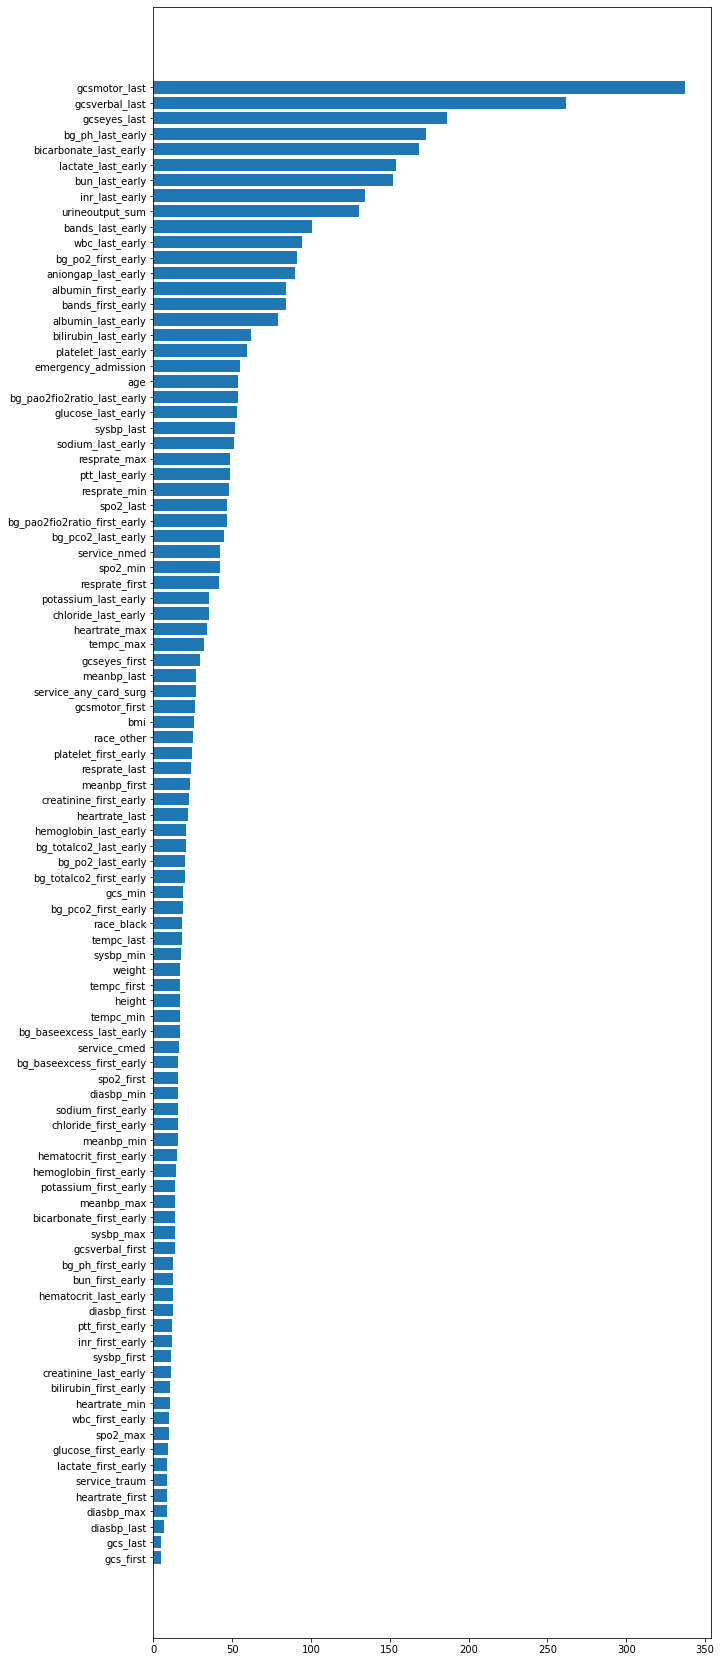

In [28]:
plt.figure(figsize=(10,30))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

## Using Lasso

In [29]:
lassoDf = pd.DataFrame(data=list(zip(X_header, mdl_val['lasso'][0].named_steps['lasso'].coef_)), columns=['feature', 'weight'])
lassoDf.sort_values('weight', inplace=True)

<BarContainer object of 108 artists>

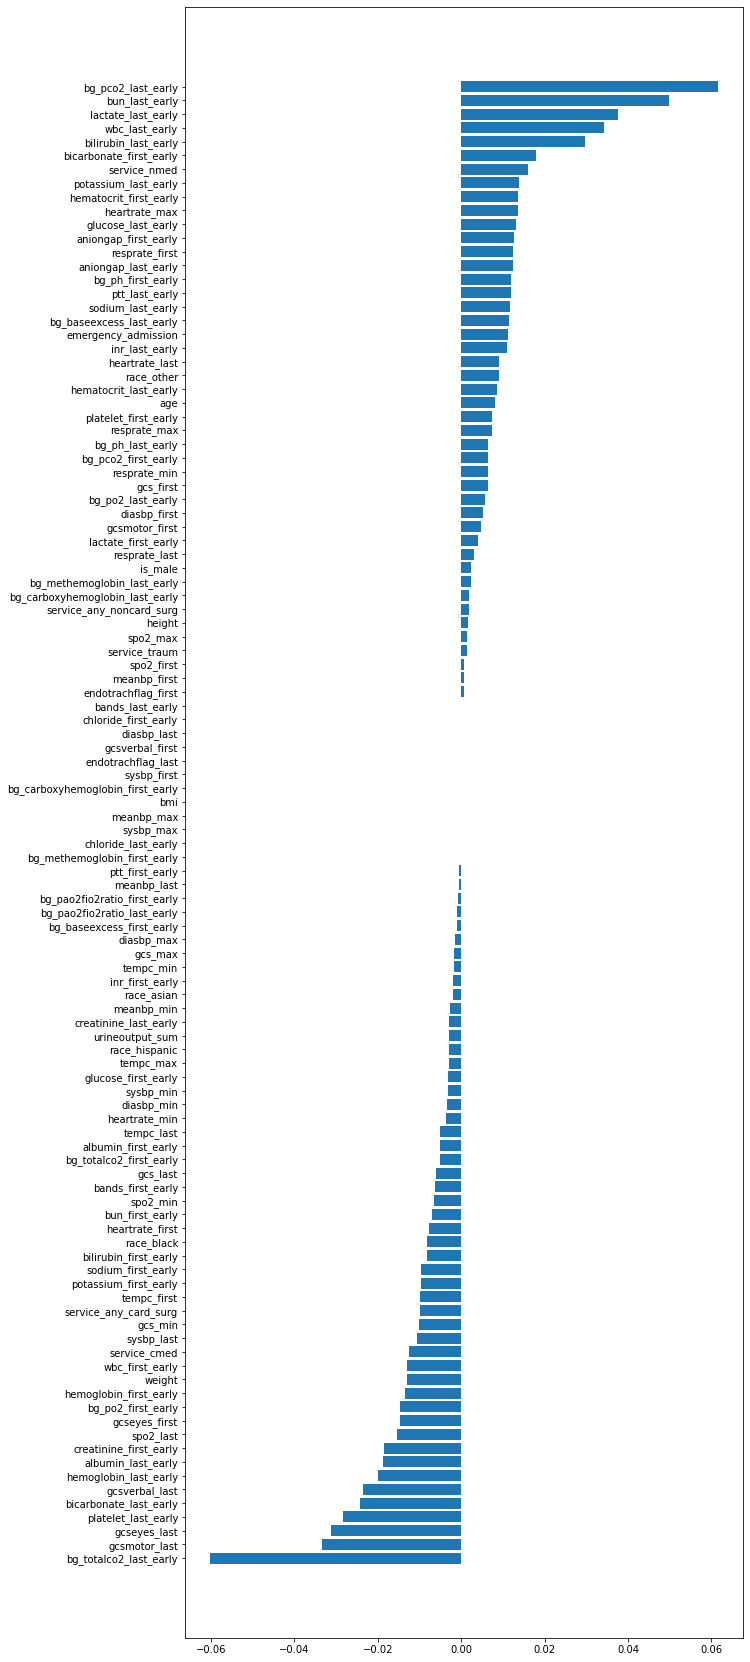

In [30]:
plt.figure(figsize=(10,30))
plt.barh(y=lassoDf.feature, width=lassoDf.weight)

## Using Random Forest

In [31]:
rfDf = pd.DataFrame(data=list(zip(X_header, mdl_val['rf'][0].named_steps['rf'].feature_importances_)), columns=['feature', 'weight'])
rfDf.sort_values('weight', inplace=True)

<BarContainer object of 108 artists>

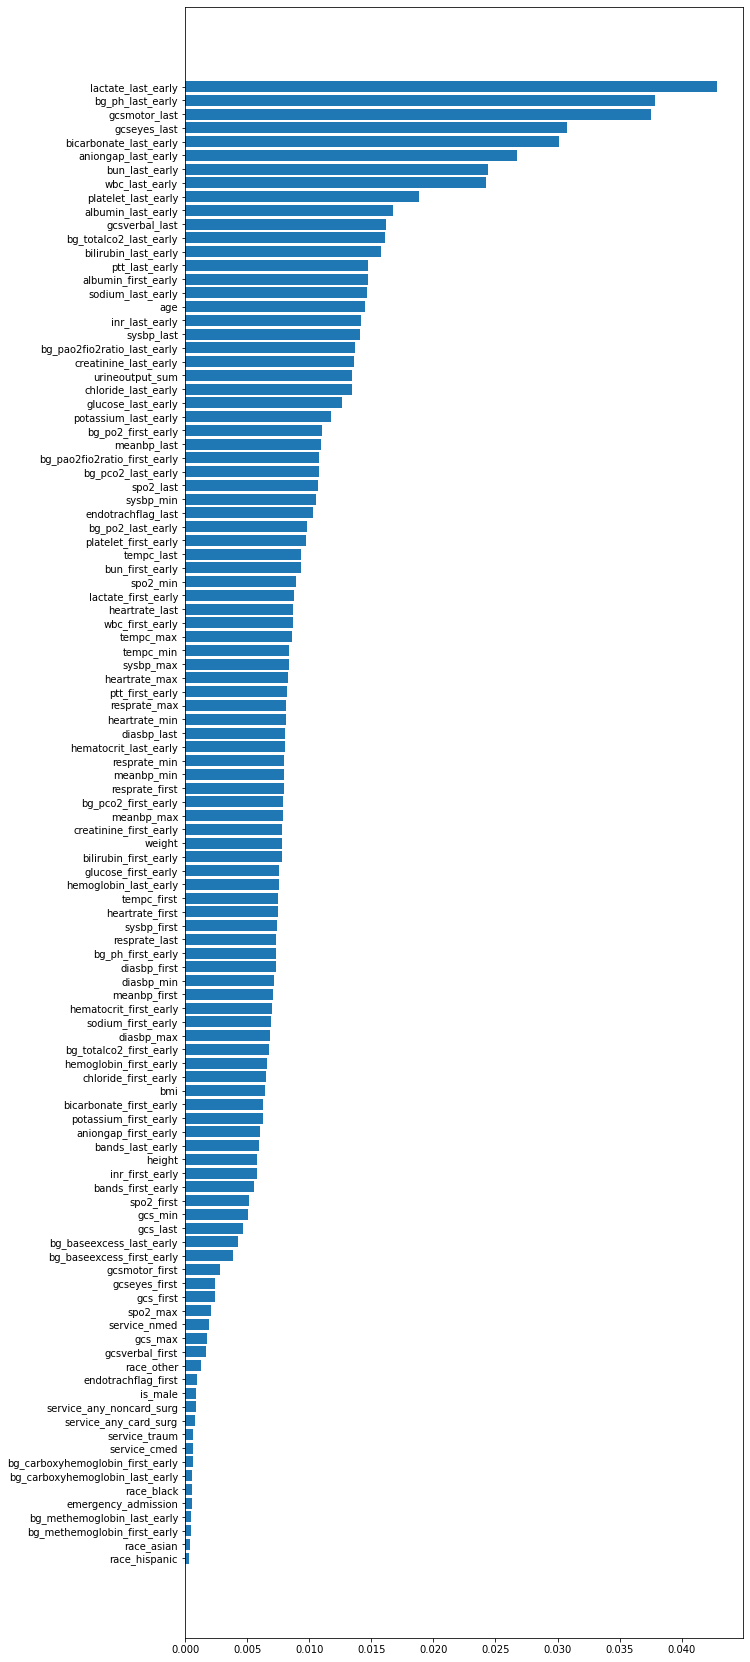

In [32]:
plt.figure(figsize=(10,30))
plt.barh(y=rfDf.feature, width=rfDf.weight)

## Using logistic regression

In [33]:
lrDf = pd.DataFrame(data=list(zip(X_header, mdl_val['logreg'][0].named_steps['logreg'].coef_[0])), columns=['feature', 'weight'])

In [34]:
lrDf.sort_values('weight', inplace=True)

<BarContainer object of 108 artists>

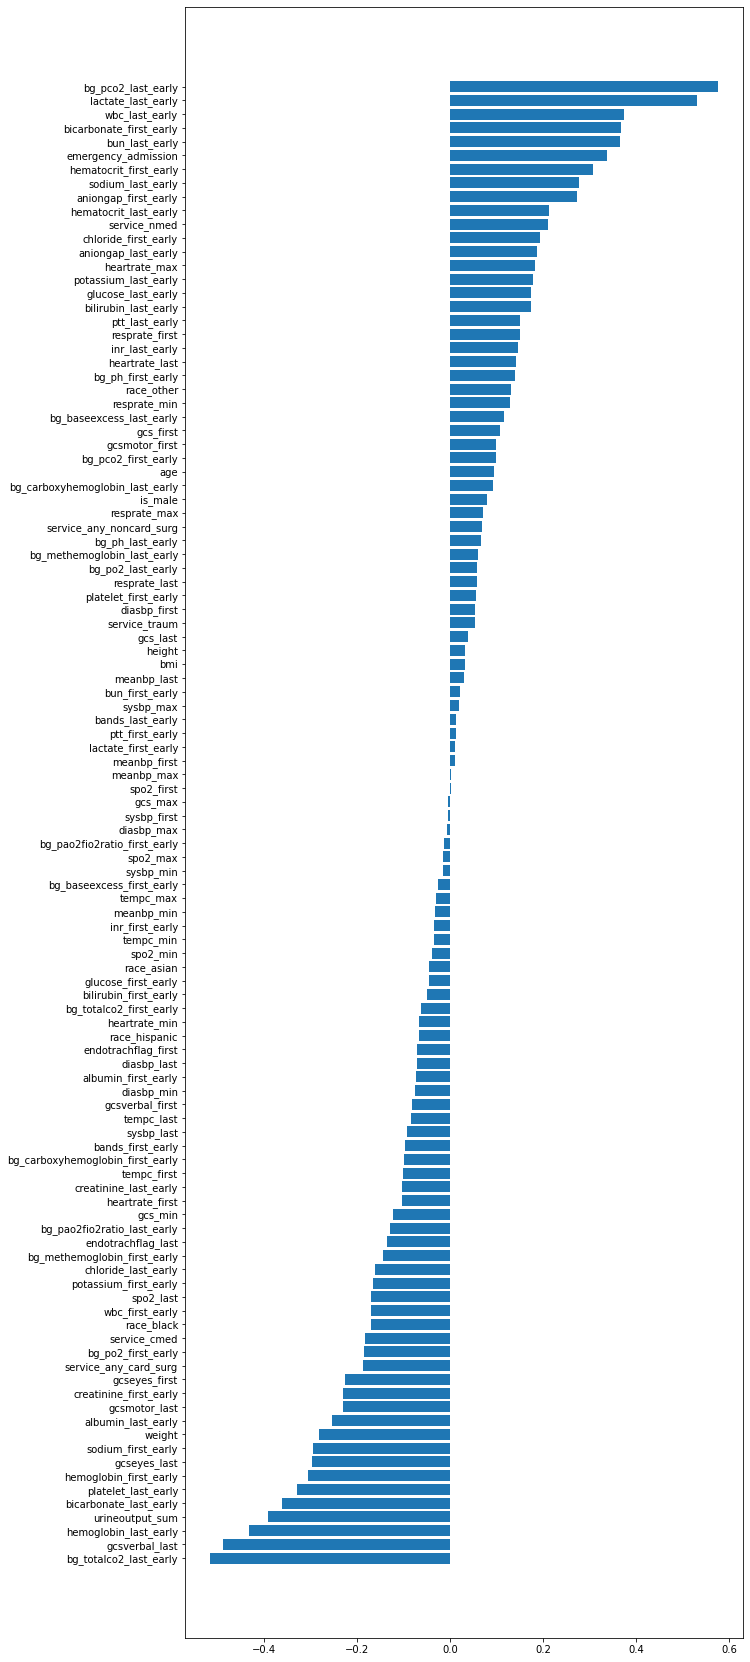

In [35]:
plt.figure(figsize=(10,30))
plt.barh(y=lrDf.feature, width=lrDf.weight)